# CS7641 Machine Learning
*Application of Machine Learning in Pairs Trading*

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

## Generate the input data

### Price history

Merge the price history of the all periods

In [2]:
training_set_price = pd.read_csv("pairs_total_stock.csv")
#print(training_set_price)
training_set_price.head(3)

,PERMNO,price_20070103,price_20070104,price_20070105,price_20070108,price_20070109,price_20070110,price_20070111,price_20070112,price_20070116,price_20070117,price_20070118,price_20070119,price_20070122,price_20070123,price_20070124,price_20070125,price_20070126,price_20070129,price_20070130,price_20070131,price_20070201,price_20070202,price_20070205,price_20070206,price_20070207,price_20070208,price_20070209,price_20070212,price_20070213,price_20070214,price_20070215,price_20070216,price_20070220,price_20070221,price_20070222,price_20070223,price_20070226,price_20070227,price_20070228,...,20191104,20191105,20191106,20191107,20191108,20191111,20191112,20191113,20191114,20191115,20191118,20191119,20191120,20191121,20191122,20191125,20191126,20191127,20191129,20191202,20191203,20191204,20191205,20191206,20191209,20191210,20191211,20191212,20191213,20191216,20191217,20191218,20191219,20191220,20191223,20191224,20191226,20191227,20191230,20191231
0,43350,50.78,51.10,50.90,50.71,51.63,52.23,52.97,53.22,53.26,53.52,54.06,53.09,53.26,53.48,53.88,52.85,55.57,55.54,56.11,57.26,58.14,58.95,57.70,58.17,58.09,57.85,57.00,56.48,56.71,57.38,57.59,57.05,57.53,57.91,57.63,57.62,57.72,55.41,55.57,...,158.28000,160.00000,159.24001,159.45000,157.84,157.94000,157.62,155.38,156.11,157.63000,156.11,156.42999,153.67000,155.09,157.28000,159.28999,158.84,158.80,157.74001,153.28,151.80,153.28000,157.39,158.87,158.59000,157.25999,159.59000,167.75999,164.53999,164.05,165.00999,165.11,165.87000,165.64,166.67999,165.09,165.66000,165.89999,165.67,165.74001
1,82651,48.88,49.22,48.67,50.55,51.14,51.90,53.76,54.71,55.05,55.32,54.95,54.96,54.88,54.97,56.59,56.25,56.07,56.05,56.10,56.69,56.73,56.26,56.50,56.53,56.24,56.40,56.21,56.29,56.67,57.45,58.04,58.00,58.40,58.30,56.15,56.03,56.07,53.96,54.24,...,214.99001,213.58000,213.07001,211.98000,210.08,209.57001,212.58,213.39,213.48,217.32001,216.34,219.72000,217.71001,217.72,218.72000,221.24001,222.06,223.55,222.07001,223.11,221.36,224.95000,223.70,226.30,226.63000,227.92999,228.97000,233.69000,234.11000,234.02,231.30000,229.00,231.87000,233.28,232.99001,233.09,233.25999,233.75999,233.19,233.64999
2,44644,48.41,48.90,48.76,48.79,48.60,48.33,48.38,48.70,48.60,48.99,48.22,47.91,47.32,47.41,47.75,47.48,47.13,47.29,47.36,47.72,48.50,49.00,49.11,48.80,48.75,48.97,48.81,49.06,50.39,51.21,50.98,50.96,50.69,50.81,50.91,51.18,51.26,49.87,49.75,...,161.88000,157.00999,159.66000,162.10001,162.73,163.42000,166.36,168.98,170.14,171.17000,170.73,171.09000,170.58000,169.86,169.64999,170.20000,171.62,171.48,170.78000,168.59,167.13,168.57001,168.36,169.98,169.07001,168.42999,167.24001,167.16000,168.25999,168.59,168.32001,167.56,168.74001,171.09,170.02000,169.91,170.35001,170.77000,169.59,170.50000


In [4]:
# Generate the column index date data for the x-label of the results
dates = np.genfromtxt('all_dates.csv', delimiter=',', dtype='object')
for i in range(len(dates)):
    if dates[i][0] == 112:
        dates[i] = dates[i][6:]
dates = dates.astype('str')
print(dates)
dates = pd.to_datetime(dates.astype(str)).values.astype('datetime64[D]')
print(dates)
dates_save = dates.astype('float')
np.savetxt('dates.csv', dates_save, delimiter=",")

['20070103' '20070104' '20070105' ... '20191227' '20191230' '20191231']
['2007-01-03' '2007-01-04' '2007-01-05' ... '2019-12-27' '2019-12-30'
 '2019-12-31']


In [5]:
# Pairs list from the clutering

pairs_list = [[43350, 82651],
                [44644, 90458],
                [24969, 24985],
                [42585, 83621],
                [60186, 81095],
                [16548, 81577]]

In [6]:
class Backtesting():
    """
    Run the backtesting and track the total asset history
    """

    def __init__(self, z_score_list, stop_loss=3, buy_z=2, sell_z=-0.5, 
                 total_money=100000):
        self.pairs_num = z_score_list.shape[0]
        self.total_time = z_score_list.shape[1]
        self.stop_loss = stop_loss
        self.buy_z = buy_z
        self.sell_z = sell_z

        self.inverse_price = np.zeros((2 * self.pairs_num))
        self.total_stock = np.zeros((2 * self.pairs_num))
        self.total_inverse = np.zeros((2 * self.pairs_num))
        self.money_for_pair = int(total_money/self.pairs_num) * \
            np.ones((self.pairs_num))

    def trade_decision(self, z_score, pair_num):
        """
        Decide whether we will buy/sell the stock/inverse.
        It is decided by z-score.

        Args:
            z_score: scalar z_score value
            pair_num: pair's number
        Return:
            stock: buy(+1), sell(-1), stop_loss(-2)
            inverse: buy(+1), sell(-1), stop_loss(-2)
        """

        stop_loss = self.stop_loss
        buy_z = self.buy_z
        sell_z = self.sell_z
        total_stock = self.total_stock[2 * pair_num]
        total_inverse = self.total_inverse[2 * pair_num]
        stock, inverse = 0, 0

        # Need to sell everything to stop loss
        if z_score >= stop_loss or z_score <= -1*stop_loss:
            stock, inverse = -2, -2

        # If the z-score is over the buy_z, buy the stock a
        elif z_score >= buy_z and total_stock == 0:
            stock, inverse = 1, 0
        
        # If the z-score below sell_z, sell all the stocks to make profit 
        elif z_score <= sell_z and total_stock > 0:
            stock, inverse = -1, 0

        # If the z-score below -1 * buy_z, buy the inverse a
        elif z_score <= -1 * buy_z and total_inverse == 0:
            stock, inverse = 0, 1

        # If the z-score above -1 * sell_z, sell the inverse a to make profit
        elif z_score >= -1 * sell_z and total_inverse > 0:
            stock, inverse = 0, -1
        
        return stock, inverse


    def cal_trade_vol(self, stock_num, stock_signal, inv_signal, current_price):
        """
        Calculate the volume of trade we will trade

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_signal: Signal to trade the stock (+: buy, -: sell)
            inv_signal: Signal to trade the inverse (+: buy, -: sell)
            current_price: current price to calculate how many stock we will 
                trade
        Return:
            trade_stock_vol: Volume of stock to buy(+) or sell(-)
            trade_inverse_vol: Volume of inverse to buy(+) or sell(-)
        """

        # Initialization
        trade_stock_vol = 0
        trade_inverse_vol = 0

        # Calculate how much money we will use for this stock
        money_for_stock = self.money_for_pair[int(stock_num/2)] / 2

        # Sell the stock if the stock_signal < 0
        if stock_signal < 0:
            trade_stock_vol = -1 * self.total_stock[stock_num]

        # Buy the stock if the stock_signal > 0
        elif stock_signal > 0:
            trade_stock_vol = int(money_for_stock/current_price)

        # Sell the inverse if the inverse_signal < 0
        if inv_signal < 0:
            trade_inverse_vol = -1 * self.total_inverse[stock_num]

        # Buy the stock if the inverse_signal > 0
        elif inv_signal > 0:
            trade_inv_vol = int(money_for_stock/current_price)

        return trade_stock_vol, trade_inverse_vol
        
    def cal_result(self, stock_num, stock_vol, inverse_vol, prev_price, current_price):
        """
        Calculate the each stock's trade results

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_vol: Volume of stock to buy(+) or sell(-)
            inverse_vol: Volume of inverse to buy(+) or sell(-)
            prev_price: Price of the stock the day before.
            current_price: Price of the stock today.
        Return:
            total_asset: Sum of all the assets today.
        """

        # Update the price of current inverse
        if self.total_inverse[stock_num] > 0:
            change_ratio = (current_price - prev_price) / prev_price
            self.inverse_price[stock_num] = (1 - change_ratio) * self.inverse_price[stock_num]
        
        # Buy the stock
        if stock_vol > 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price

        # Sell the stock
        elif stock_vol < 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price
        
        # Buy the inverse
        if inverse_vol > 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * current_price
            self.inverse_price[stock_num] = current_price
        
        # Sell the inverse
        if inverse_vol < 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * self.inverse_price[stock_num]
            self.inverse_price[stock_num] = 0

        total_asset = (self.total_inverse[stock_num] * self.inverse_price[stock_num] + 
                          self.total_stock[stock_num] * current_price)

        return total_asset


    def backtesting(self, z_score_list, price_list):
        """
        Args:
            z_score_list: list of z-score history (NxT).
            price_list: list of price history (2NxT).
        Return:
            final asset history
        """

        total_asset = np.zeros((self.pairs_num, self.total_time))

        for t in range(self.total_time):
            for pair_num in range(self.pairs_num):
                stock_a_num = 2*pair_num
                stock_b_num = 2*pair_num+1
                z_score = z_score_list[pair_num]
            
                # Decide whether buy or sell stock a.
                stock_a, inverse_a = self.trade_decision(
                    z_score[t], pair_num)
                stock_b = inverse_a
                inverse_b = stock_a

                # Calculate the buy/sell volume
                stock_a_vol, inverse_a_vol = self.cal_trade_vol(
                    stock_a_num, stock_a, inverse_a, price_list[stock_a_num][t])
                stock_b_vol, inverse_b_vol = self.cal_trade_vol(
                    stock_b_num, stock_b, inverse_b, price_list[stock_b_num][t])

                # Calculate the trade result
                total_asset[pair_num][t] += self.cal_result(stock_a_num, stock_a_vol, 
                                                  inverse_a_vol, 
                                                  price_list[stock_a_num][t-1], 
                                                  price_list[stock_a_num][t])
                
                total_asset[pair_num][t] += self.cal_result(stock_b_num, stock_b_vol,
                                                     inverse_b_vol, 
                                                     price_list[stock_b_num][t-1], 
                                                     price_list[stock_b_num][t])

                total_asset[pair_num][t] += self.money_for_pair[int(pair_num)]

        return total_asset

## Run the code with pairs

Now, let's run the backtesting and get the money

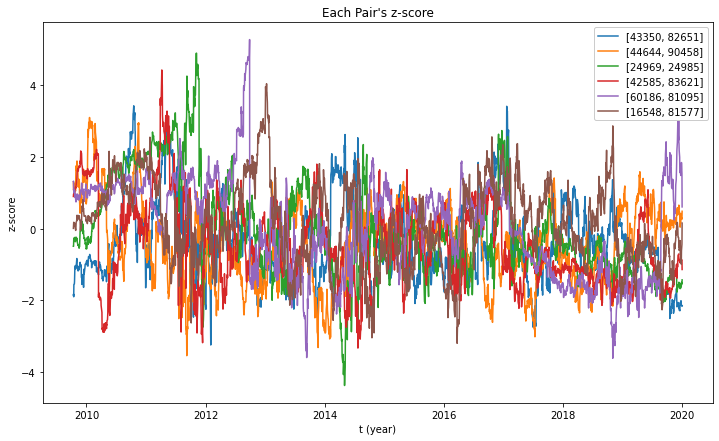

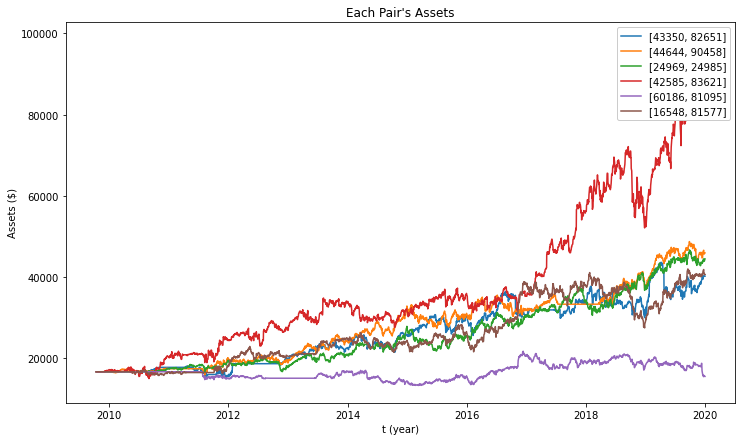

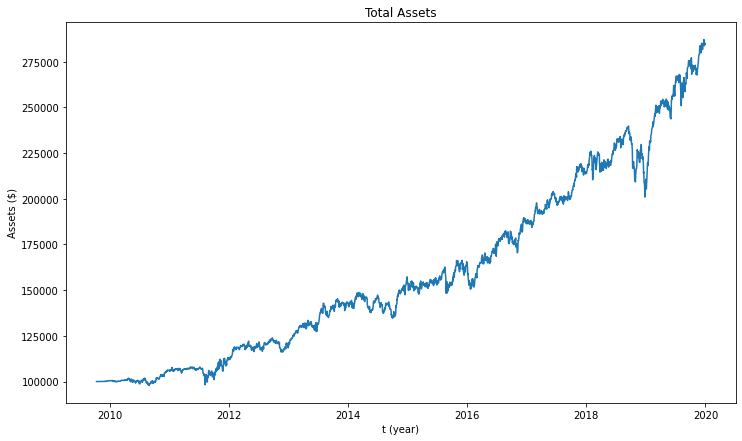

Total earning ratio: 2.8443810342


In [7]:
# Read the z-score history list.
with open('z_score_history.npy', 'rb') as infile:
    z_score_list = np.load(infile)
    z_score_list = z_score_list[:len(pairs_list)]

# Remove the initial 700 data. We generate the z-score after 700 days.
price_list = training_set_price.to_numpy()[:, 700:]

# Initial money is $100000.
initial_money = 100000

# Run the backtesting code
BT = Backtesting(z_score_list, total_money = initial_money)
asset_per_pair = BT.backtesting(z_score_list, price_list)

# Plot the graphs about results
x = np.arange(z_score_list.shape[1])
x = dates[700:]

# Graph about each pair's z-score
plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s z-score')
plt.ylabel('z-score')
plt.xlabel('t (year)')
for i, pair in enumerate(pairs_list):
    plt.plot(x, z_score_list[i], label=str(pair))
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_z_score.png')
plt.show()

# Graph about each pair's assets
plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (year)')
for i, pair in enumerate(pairs_list):
    plt.plot(x, asset_per_pair[i], label=str(pair))
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_assets.png')
plt.show()

# Graph about total asset
plt.figure(figsize=(12, 7))
plt.title('Total Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (year)')
total_asset = np.sum(asset_per_pair, axis=0)
plt.plot(x, total_asset)
plt.savefig('total_assets.png')
plt.show()

# Calculate the total earning
total_earning_ratio = total_asset[-1] / initial_money
print("Total earning ratio: " + str(total_earning_ratio))

# Save the total assets
total_asset_history = pd.DataFrame(
    total_asset,
    index=x,
    columns=['total assets']
)
total_asset_history.to_csv('total_asset_history.csv', index=True)